# Single-cell RNA Sequencing of human scalp: Preprocessing

Data Source Acknowledgment: The dataset is sourced from [GSE212450](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212450). This notebook uses sub-dataset which comprises single-cell RNA sequencing data from human scalp with alopecia areata (GSM6532922	AA8_scRNA) and control (GSM6532927	C_SD2_scRNA).

Reference: Ober-Reynolds B, Wang C, Ko JM, Rios EJ et al. Integrated single-cell chromatin and transcriptomic analyses of human scalp identify gene-regulatory programs and critical cell types for hair and skin diseases. Nat Genet 2023 Aug;55(8):1288-1300. PMID: 37500727

It's essential to emphasize that this dataset is exclusively utilized for Python practice purposes within this repository. This notebook will use this dataset to practice data cleaning techniques and clustering.

In [4]:
#using SCanalysis environment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad

In [5]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [6]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,)

## 1. Data Loading

In [4]:
#loading control
adata_CON = sc.read_10x_mtx('./SD2')

In [23]:
adata_CON

AnnData object with n_obs × n_vars = 3313 × 33538
    var: 'gene_ids', 'feature_types'

In [32]:
#h5ad file will use for celllblender
adata_CON.write_h5ad('adata_CON.h5ad')

In [10]:
#loading case
adata_CASE = sc.read_10x_mtx('./AA2', prefix='GSM6532919_AA2_')

In [11]:
adata_CASE

AnnData object with n_obs × n_vars = 7503 × 33538
    var: 'gene_ids', 'feature_types'

In [33]:
adata_CASE.write_h5ad('adata_CASE.h5ad')

## 2. Ambient removal

***Using Cellbender***: I just want to practice to run the cb. I used defalt command. The input of cb is raw_feature_bc_matrix.h5. However, I dont have those files and both h5ad file are already preprocess for ambient removal.

In [ ]:
#using cellblender environment
#!cellbender remove-background --input adata_CASE.h5ad --output adata_CASE_cleaned.h5ad

In [ ]:
#!cellbender remove-background --input adata_CON.h5ad --output adata_CON_cleaned.h5ad

In [3]:
adata_CON_cb = sc.read_10x_h5('adata_CON_cleaned_filtered.h5')

In [4]:
adata_CON_cb

AnnData object with n_obs × n_vars = 1069 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
adata_CASE_cb = sc.read_10x_h5('adata_CASE_cleaned_filtered.h5')

In [6]:
adata_CASE_cb

AnnData object with n_obs × n_vars = 1810 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
df_metrics_con = pd.read_csv('adata_CON_cleaned_metrics.csv')
df_metrics_case = pd.read_csv('adata_CASE_cleaned_metrics.csv')
combined_metrics = df_metrics_con.merge(df_metrics_case, how='inner')

In [8]:
combined_metrics.columns = range(len(combined_metrics.columns))
combined_metrics

,0,1,2
0,total_output_counts,1.609675e+07,2.040112e+07
1,total_counts_removed,8.136444e+06,1.130331e+07
2,fraction_counts_removed,3.360000e-01,3.570000e-01
3,total_raw_counts_in_cells,2.423319e+07,3.170443e+07
4,total_counts_removed_from_cells,8.136444e+06,1.130331e+07
5,fraction_counts_removed_from_cells,3.360000e-01,3.570000e-01
6,average_counts_removed_per_cell,7.611267e+03,6.244922e+03
7,target_fpr,1.000000e-02,1.000000e-02
8,expected_cells,2.990000e+02,5.170000e+02
9,found_cells,1.069000e+03,1.810000e+03


## 3. Preprocessing

### 3.1 Quality control

In [28]:
def qc(adata):
    #label mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    #label ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    #label hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    #remove column we dont use
    remove_list = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
                  'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove_list]]
    return adata

In [29]:
#CASE
adata_CASE = sc.read('adata_CASE.h5ad')
adata_CASE

AnnData object with n_obs × n_vars = 7503 × 33538
    var: 'gene_ids', 'feature_types'

In [30]:
adata_CASE = qc(adata_CASE)

In [31]:
adata_CASE

AnnData object with n_obs × n_vars = 7503 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

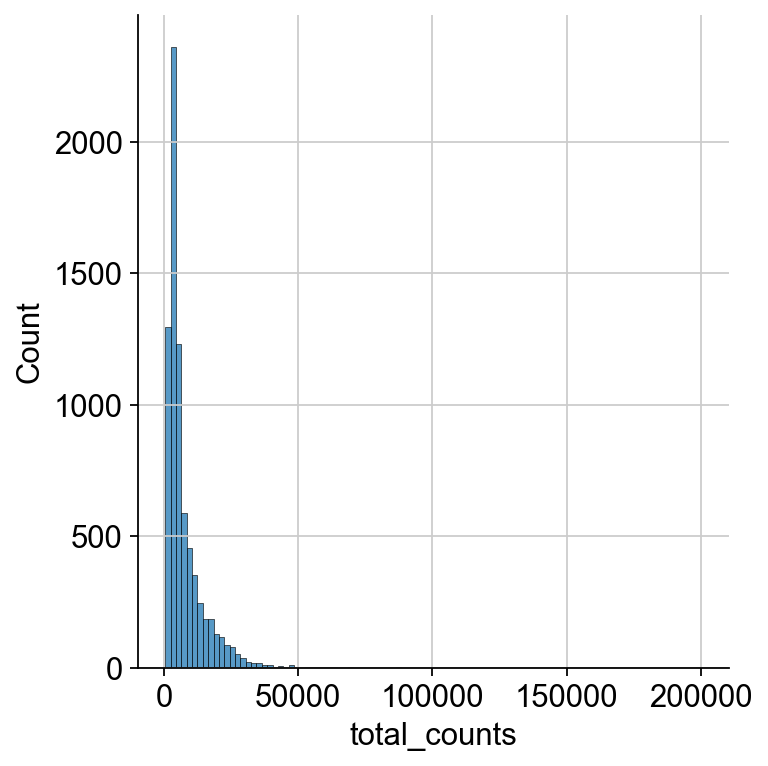

In [32]:
sns.displot(adata_CASE.obs['total_counts'], bins=100)

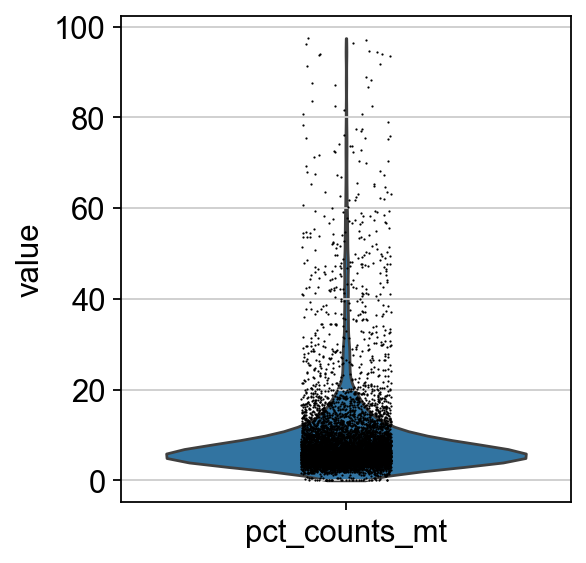

In [33]:
sc.pl.violin(adata_CASE, 'pct_counts_mt')

In [40]:
adata_CASE[adata_CASE.obs['pct_counts_mt'] > 25]

View of AnnData object with n_obs × n_vars = 383 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

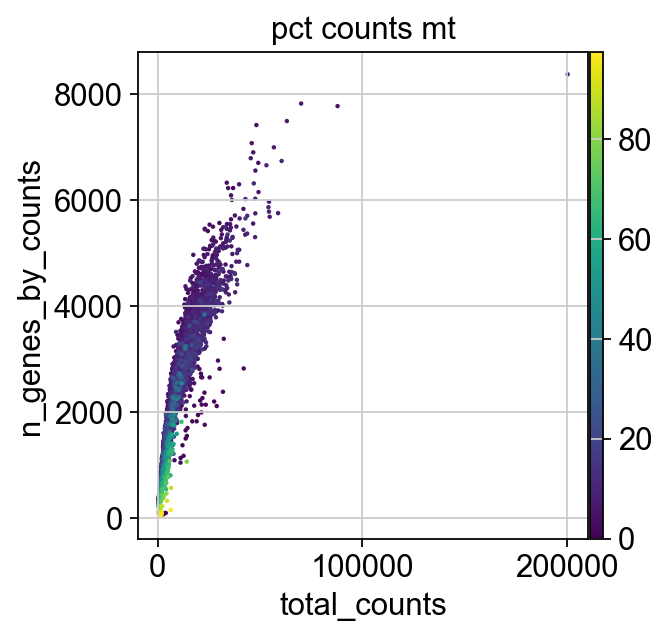

In [41]:
sc.pl.scatter(adata_CASE, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [42]:
#CONTROL
adata_CON = sc.read('adata_CON.h5ad')
adata_CON

AnnData object with n_obs × n_vars = 3313 × 33538
    var: 'gene_ids', 'feature_types'

In [43]:
adata_CON = qc(adata_CON)

In [44]:
adata_CON

AnnData object with n_obs × n_vars = 3313 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

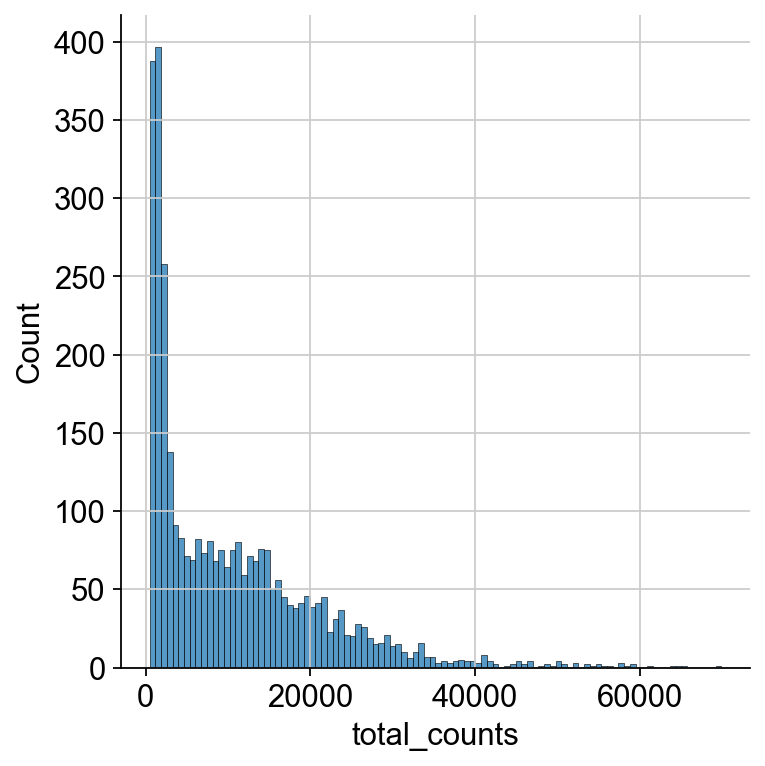

In [45]:
sns.displot(adata_CON.obs['total_counts'], bins=100)

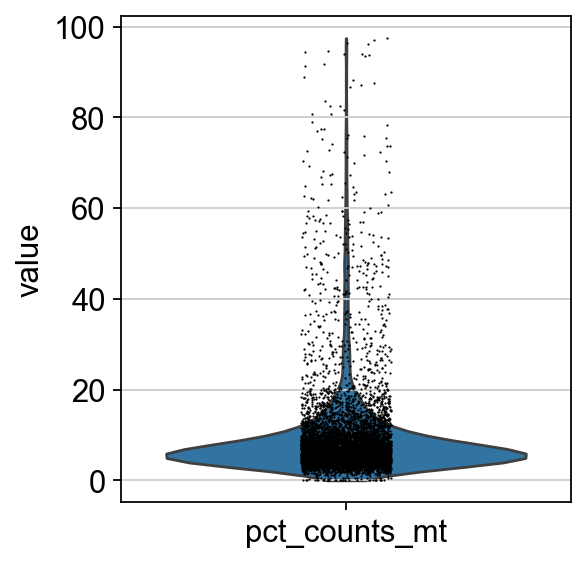

In [46]:
sc.pl.violin(adata_CASE, 'pct_counts_mt')

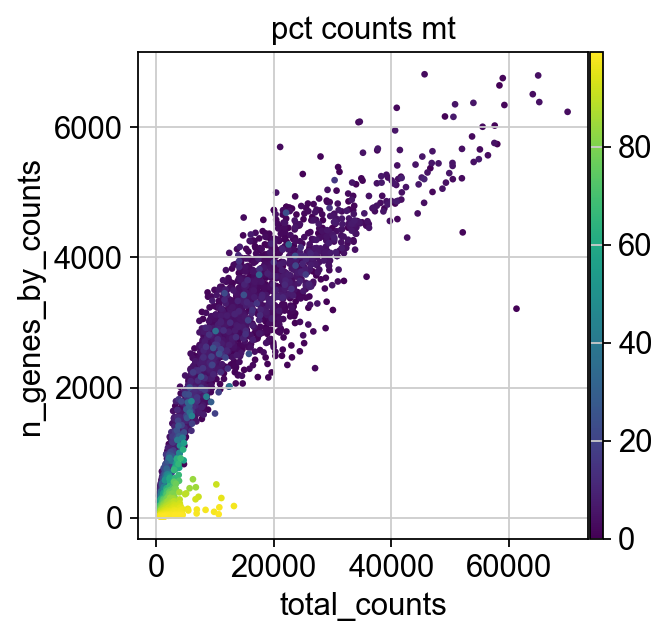

In [47]:
sc.pl.scatter(adata_CON, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### 3.2 Filtering low quality cells based on qc matrix

In [48]:
# MAD (median absolute deviations)
from scipy.stats import median_abs_deviation as mad

In [49]:
a = adata_CASE.obs['log1p_total_counts']

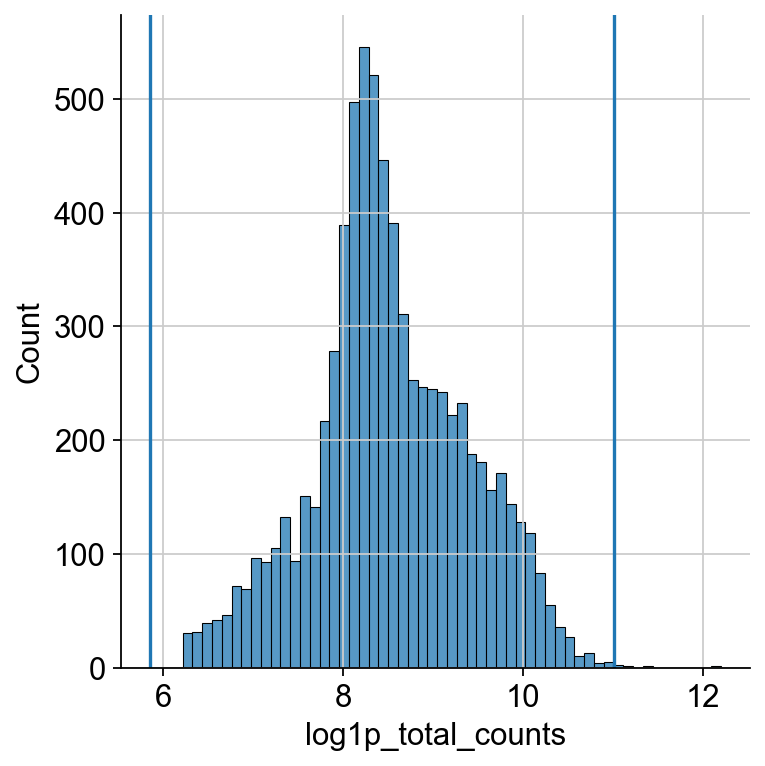

In [50]:
ax = sns.displot(a)

plt.axvline(np.median(a) - 5 * mad(a))
plt.axvline(np.median(a) + 5 * mad(a))

plt.show()

In [51]:
def MAD_outlier(adata, metric, nmads, upper_only=False):
    M = adata.obs[metric]
    
    if not upper_only: #some dont want to exclude data with lower mad threshold e.g. mt
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
        
    return (M > np.median(M) + nmads * mad(M))

In [57]:
def preprocessing(adata):
    adata = adata[adata.obs.pct_counts_mt < 25]
    #if it is outlier = TRUE
    bool_vector = MAD_outlier(adata, 'log1p_total_counts', 5) +\
            MAD_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            MAD_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            MAD_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    return adata

In [58]:
#case
adata_CASE_pp = preprocessing(adata_CASE)
adata_CASE_pp

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3397/3987471672.py:10: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['cells_removed'] = sum(bool_vector)


AnnData object with n_obs × n_vars = 6202 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed'

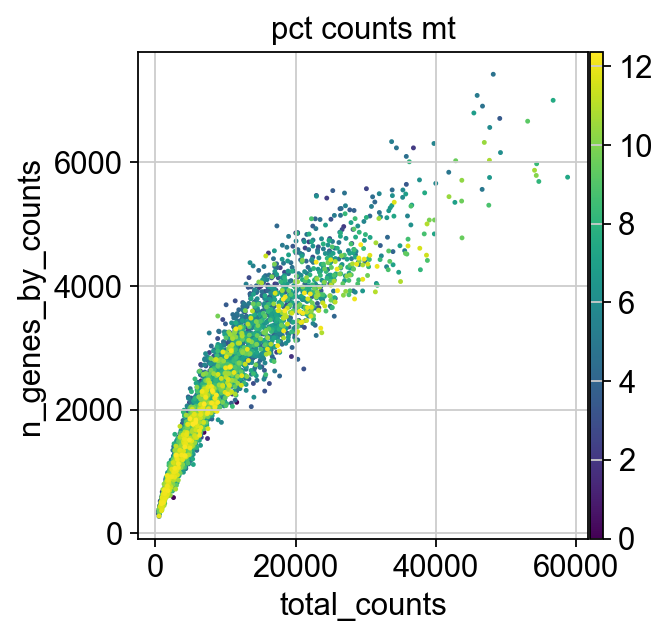

In [59]:
sc.pl.scatter(adata_CASE_pp, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [54]:
#control
adata_CON_pp = preprocessing(adata_CON)
adata_CON_pp

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3397/3987471672.py:10: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['cells_removed'] = sum(bool_vector)


AnnData object with n_obs × n_vars = 2155 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed'

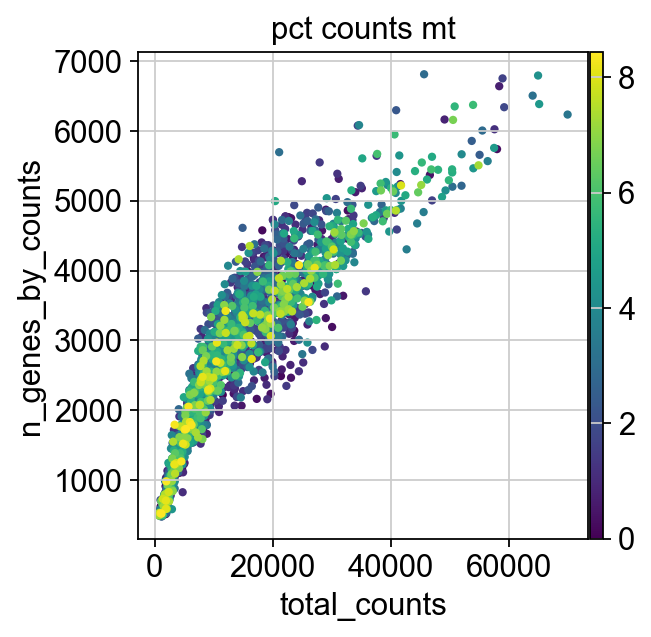

In [60]:
sc.pl.scatter(adata_CON_pp, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### 3.3 Doublet detection

In [61]:
def remove_doublet(adata):
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]

    adata = sc.read(adata)
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    
    return adata